This jupyter notebook provide a easy-to-follow tutorial to generate splits in a St-fashion, in which proteins within every fold will belong to specific protein families. 
We will use the Chembl database that offers the labelling of every protein to each protein family. 

In [9]:
import pandas as pd
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import random
import itertools

We will use the DrugBank dataset for this tutorial, which we have made available in the tutorial folder of this repository

In [10]:
# Load the DTI network in the form of a 2-columns file.
drugbank_dtis = pd.read_csv(os.path.join('data','drugbank_dtis.tsv'),sep='\t', index_col=0)
drugbank_dtis

,Drug ID,Gene
0,DB00002,P08637
1,DB00002,P12314
2,DB00004,P31785
3,DB00005,P02747
4,DB00006,P00734
...,...,...
26414,DB16703,Q13464
26415,DB16703,O75116
26416,DB16703,P10632
26417,DB16733,Q9H2S1


In [11]:
# Load a generated pickle file that contains several protein families for 6k+ proteins
proteins_annot_full = pd.read_pickle(os.path.join('data','proteins_annot_full.pkl'))[['id','Class']]
proteins_annot_full

,id,Class
0,P32397,enzyme
1,H0YE48,notAnnotated
2,P27694,dna-binding
3,P80188,notAnnotated
4,O14594,notAnnotated
...,...,...
6161,Q03405,receptor
6162,A1L3X4,notAnnotated
6163,P08183,enzyme
6164,Q15858,ion channel


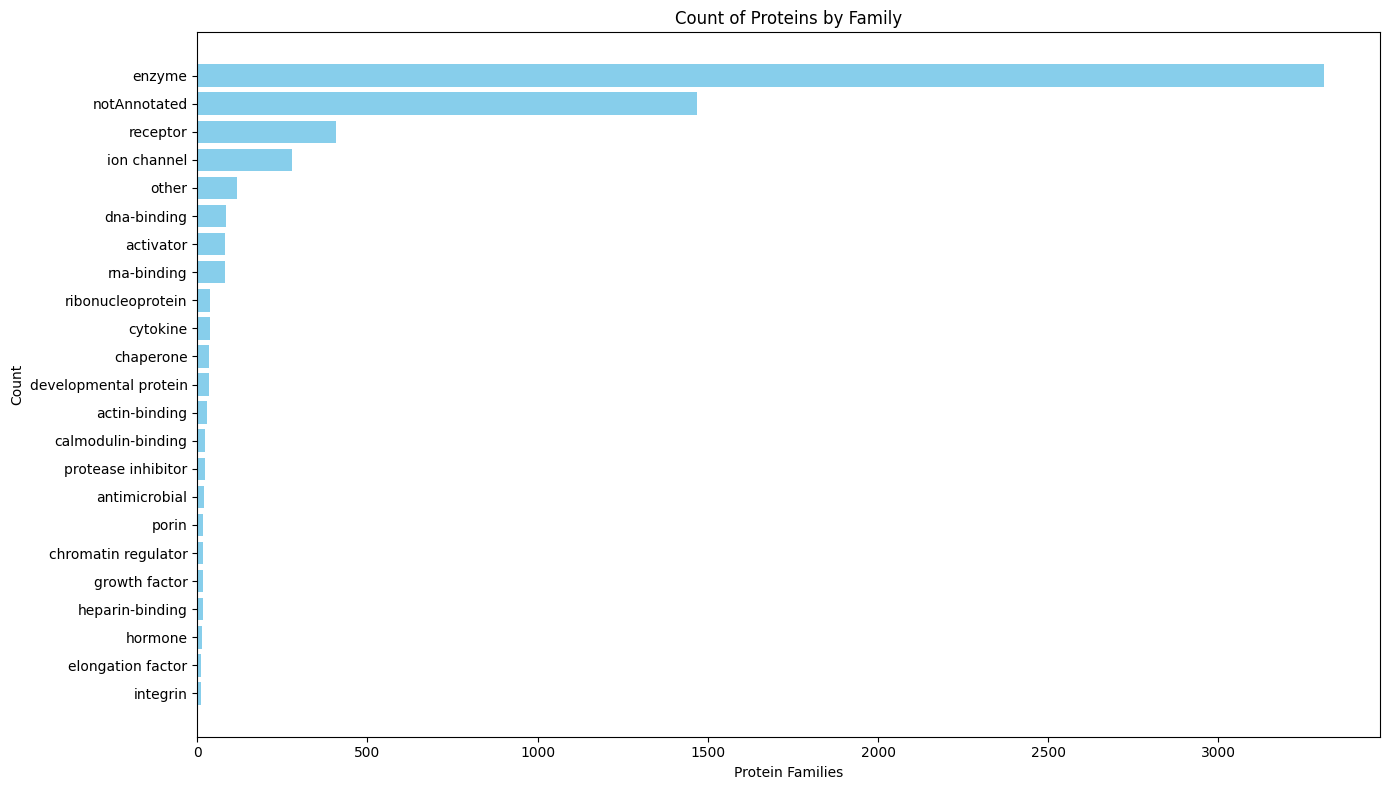

In [12]:
pfamilies_counter = Counter(proteins_annot_full['Class'])

# Prepare the data for plotting
pfamilies = [(k,v) for k,v in pfamilies_counter.items()]
pfamilies = sorted(pfamilies, key=lambda x:x[1], reverse=False)

# Create the bar plot
plt.figure(figsize=(14, 8))
plt.barh(list(map(lambda x: x[0], pfamilies)), list(map(lambda x: x[1], pfamilies)), color='skyblue')
plt.xlabel('Protein Families')
plt.ylabel('Count')
plt.title('Count of Proteins by Family')
plt.tight_layout()


We will work with 2 dictionaries containing protein-to-aminoacid sequence mapping, and drug-to-smile sequence mapping, respectively. We have already generated pickle files for this purpose.

In [13]:
## load drug-smile dict
with open(os.path.join('data','smile_dict.pickle'), 'rb') as handle:
    smile_dict = pickle.load(handle)
    
## load protein-aa seq dict
with open(os.path.join('data','aa_dict.pickle'), 'rb') as handle:
    aa_dict = pickle.load(handle)

As it can be seen in the figure, this labelling is highly imbalance, so we will use a cross-validation fashion to evaluate each of the folds, except for "notAnnotated" and "other" categories, but we will consider them for training in order not to drop interactions.

In [19]:
def build_row(df):

    df_drugs, df_genes = df.iloc[:,0].values, df.iloc[:,1].values

    smiles_drugs = list(map(lambda x: smile_dict[x], df_drugs))
    aa_seq = list(map(lambda x: aa_dict[x], df_genes))

    df['SMILES'] = smiles_drugs
    df['Target Sequence'] = aa_seq

    return df

#set of protein families
protein_classes = proteins_annot_full['Class'].unique()

#init vars to store folds
folds_dict = {}
folds = []

#init seed
seed = 42
drugs = drugbank_dtis.iloc[:,0].values

for pclass in tqdm(protein_classes, desc = 'iterating protein classes... for St'):
    
    #get subdataset
    proteins_pclass = proteins_annot_full[proteins_annot_full['Class'] == pclass]['id'].unique()

    print(f"class {pclass} - we are using {len(proteins_pclass)}")

    #get all positive interactions with cids drugss
    pos_interactions_sclass = drugbank_dtis[drugbank_dtis.iloc[:,1].isin(proteins_pclass)].reset_index(drop=True)
    sclass_prots = set(pos_interactions_sclass.iloc[:,1].values)

    #subsample as many negatives as positive we have
    set_pos_interactions_sclass = set([tuple(x) for x in pos_interactions_sclass.values])
    random.seed(seed)
    neg_interactions = random.sample(set(itertools.product(drugs, sclass_prots)).difference(set_pos_interactions_sclass), pos_interactions_sclass.shape[0])
    
    #build pos and neg dataframes
    neg_interactions_sclass = pd.DataFrame(neg_interactions)
    neg_interactions_sclass.columns = ['Drug ID', 'Gene']
    pos_interactions_sclass['Label'] = 1
    neg_interactions_sclass['Label'] = 0

    #build a dataframe
    sclass_df = build_row(pd.concat([pos_interactions_sclass, neg_interactions_sclass]))
    sclass_df = sclass_df.sample(frac=1, random_state=seed)
    folds_dict[pclass] = sclass_df
    folds.append(sclass_df)

## check St
for i in range(len(folds)):
    train_prots = set(pd.concat(folds[:i] + folds[i+1:])['Gene'])
    test_prots = set(folds[i]['Gene'])
    assert train_prots.intersection(test_prots) == set()


iterating protein classes... for St:   0%|          | 0/23 [00:00<?, ?it/s]

class enzyme - we are using 3309


iterating protein classes... for St:   4%|▍         | 1/23 [00:21<07:51, 21.42s/it]

class notAnnotated - we are using 1467


iterating protein classes... for St:  17%|█▋        | 4/23 [00:29<01:26,  4.57s/it]

class dna-binding - we are using 83
class developmental protein - we are using 33
class receptor - we are using 408


iterating protein classes... for St:  22%|██▏       | 5/23 [00:31<01:02,  3.47s/it]

class ion channel - we are using 278


iterating protein classes... for St:  26%|██▌       | 6/23 [00:32<00:46,  2.71s/it]

class chromatin regulator - we are using 17
class rna-binding - we are using 81


iterating protein classes... for St:  35%|███▍      | 8/23 [00:32<00:22,  1.47s/it]

class other - we are using 116


iterating protein classes... for St:  52%|█████▏    | 12/23 [00:33<00:06,  1.69it/s]

class cytokine - we are using 36
class actin-binding - we are using 29
class chaperone - we are using 34
class activator - we are using 82


iterating protein classes... for St:  78%|███████▊  | 18/23 [00:34<00:01,  4.90it/s]

class integrin - we are using 11
class protease inhibitor - we are using 24
class elongation factor - we are using 12
class heparin-binding - we are using 16
class calmodulin-binding - we are using 24
class porin - we are using 18
class ribonucleoprotein - we are using 38


iterating protein classes... for St: 100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


class hormone - we are using 14
class growth factor - we are using 16
class antimicrobial - we are using 20


Lets check if they accomplish Sd requirements, i.e., every drug in each fold does not appear in any other fold

In [20]:
## check St
for i in range(len(folds)):
    train_prots = set(pd.concat(folds[:i] + folds[i+1:])['Gene'])
    test_prots = set(folds[i]['Gene'])
    assert train_prots.intersection(test_prots) == set()
    print(f"fold {i} - St accomplish!")

fold 0 - St accomplish!
fold 1 - St accomplish!
fold 2 - St accomplish!
fold 3 - St accomplish!
fold 4 - St accomplish!
fold 5 - St accomplish!
fold 6 - St accomplish!
fold 7 - St accomplish!
fold 8 - St accomplish!
fold 9 - St accomplish!
fold 10 - St accomplish!
fold 11 - St accomplish!
fold 12 - St accomplish!
fold 13 - St accomplish!
fold 14 - St accomplish!
fold 15 - St accomplish!
fold 16 - St accomplish!
fold 17 - St accomplish!
fold 18 - St accomplish!
fold 19 - St accomplish!
fold 20 - St accomplish!
fold 21 - St accomplish!
fold 22 - St accomplish!


Everything looks good, now we can save these folds. For every fold, 3 (train, val, test) .csv files will be generated.
The test will contain interactions where drugs accomplish Sd constraints, and only belong to a single Superclass category.

In [18]:
#generate folder
seed_fpath = os.path.join('data','splits_chembl_drugbank',f'seed_{seed}')
if not os.path.exists(seed_fpath):
    os.makedirs(seed_fpath)

#then folds
info = []
for i in range(len(folds)):

    #we will not save notAnnotated or other
    if protein_classes[i] == 'notAnnotated' or protein_classes[i] == 'other':
        continue

    #
    info.append((i, protein_classes[i], folds[i].shape[0]))

    #create folder
    fold_fpath = os.path.join(seed_fpath, f'fold{i}')
    if not os.path.exists(fold_fpath):
        os.makedirs(fold_fpath)

    #create train val and test
    train_drugs = pd.concat(folds[:i] + folds[i+1:]).reset_index(drop=True)
    test_drugs = folds[i].reset_index(drop=True)
    train_drugs, val_drugs = train_test_split(train_drugs, test_size = 0.2)

    ##save it
    train_drugs.to_csv(os.path.join(fold_fpath, 'train.csv'))
    val_drugs.to_csv(os.path.join(fold_fpath, 'val.csv'))
    test_drugs.to_csv(os.path.join(fold_fpath, 'test.csv'))

#build info dataframe and save it
info_df = pd.DataFrame(info)
info_df.columns = ['fold','proteinclass', '#edges']
info_df.to_csv(os.path.join('data','splits_chembl_drugbank', 'info.tsv'),sep='\t')

These folds can be easily run by some of the inductive methods evaluated in the paper, such as Moltrans or HyperAttentionDTI. 
For instance, you can run Moltrans on these folds using the following commands: